# classifier
Classifies each tweet according to the train set, which was classified by collaborators of the Infodengue project. 

Observations:
* Do not use stemming, because of the text content of tweets.
* For sklearn, check the text preprocessing
* Useing tweet tokenizer from nltk
* Using only TF for preprocessing
* baseline: random forest, logistic, xgboost

In [35]:
import os
import pandas as pd
import numpy as np
import pickle
from collections import Counter
import math
import nltk
import requests
import html
from datetime import datetime, timedelta, date
import string
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
import statsmodels as sm

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [59]:
outputs = "../outputs/"

In [60]:
classifications = pd.read_csv(os.path.join('../outputs/from_anvil/', 'classifications_finished.csv'))

In [61]:
classifications = classifications.groupby(by='str_id').sum()
classifications['class'] = classifications['relevance'].apply(lambda x: 1 if x>=4 else 0)
classifications['class_threshold3'] = classifications['relevance'].apply(lambda x: 1 if x>=3 else 0)
classifications.reset_index(inplace=True)
classifications.rename(columns = {'str_id': 'id'}, inplace=True)

In [62]:
anvil_input = pd.read_json(os.path.join(outputs, "tweets_anvil_input.json"))

In [63]:
data = pd.merge(classifications, anvil_input, on='id')
data.drop(columns=['tid', 'count'], inplace=True)
data

,id,relevance,class,class_threshold3,message
0,699069305468551169,2,0,0,Brasil tera 55 mil militares nas ruas para com...
1,699164279472263170,3,0,1,Depois do exercito abandonar o combate aos foc...
2,699266282646994944,3,0,1,Farmaceuticos recebem treinamento sobre dengue...
3,699317409254133760,0,0,0,RT @BolsonaroZuero: eu assistindo o pronunciam...
4,699389002210791429,2,0,0,To com um desconforto no olho que certo que e ...
...,...,...,...,...,...
574,1000179821836718083,0,0,0,meu ccat e mais parado que agua da dengue
575,1000235160485466112,0,0,0,Fala pro Ceis que eu n curto mto ir na igreja ...
576,1000376954342854656,0,0,0,RT @RGLIMA: @DaniloGentili Inundou? Chama o Ex...
577,1000527883331358720,4,1,1,Dengue e Chikungunya - O perigo aumentou. E a ...


# basic exploration

In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 579 entries, 0 to 578
Data columns (total 5 columns):
id                  579 non-null int64
relevance           579 non-null int64
class               579 non-null int64
class_threshold3    579 non-null int64
message             579 non-null object
dtypes: int64(4), object(1)
memory usage: 27.1+ KB


In [65]:
data.describe()

,id,relevance,class,class_threshold3
count,5.790000e+02,579.000000,579.000000,579.000000
mean,8.403494e+17,1.329879,0.155440,0.229706
std,1.131194e+17,1.700800,0.362637,0.421008
min,6.990693e+17,0.000000,0.000000,0.000000
25%,7.093156e+17,0.000000,0.000000,0.000000
50%,8.461445e+17,1.000000,0.000000,0.000000
75%,9.828123e+17,2.000000,0.000000,0.000000
max,1.000764e+18,6.000000,1.000000,1.000000


# check if data is unbalanced

**Data is unbalanced!**

### Threshold 4

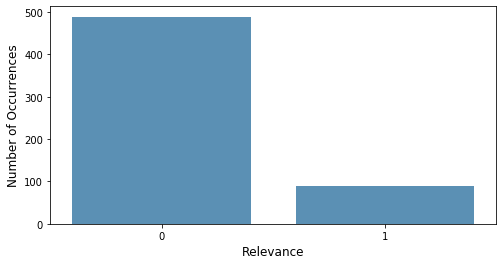

In [68]:
color = sns.color_palette()
classif = data['class'].value_counts()
plt.figure(figsize=(8,4))
sns.barplot(is_dup.index, classif.values, alpha=0.8, color=color[0])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Relevance', fontsize=12)
plt.show()

In [69]:
data['class'].value_counts()

0    489
1     90
Name: class, dtype: int64

### Threshold 3

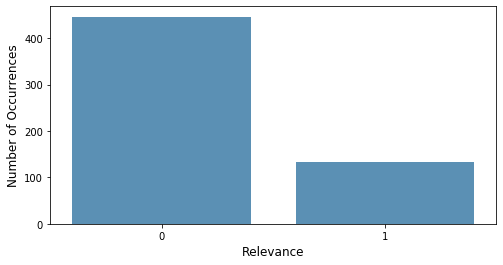

In [70]:
color = sns.color_palette()
classif = data['class_threshold3'].value_counts()
plt.figure(figsize=(8,4))
sns.barplot(is_dup.index, classif.values, alpha=0.8, color=color[0])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Relevance', fontsize=12)
plt.show()

In [72]:
data['class_threshold3'].value_counts()

0    446
1    133
Name: class_threshold3, dtype: int64

# tokenize
using TweetTokenizer from nltk. Also gets lowercase text.

In [11]:
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()

In [12]:
data['tokens'] = data['message'].apply(lambda x: tknzr.tokenize(x.lower()))
data.head()['tokens']

0    [brasil, tera, 55, mil, militares, nas, ruas, ...
1    [depois, do, exercito, abandonar, o, combate, ...
2    [farmaceuticos, recebem, treinamento, sobre, d...
3    [rt, @bolsonarozuero, :, eu, assistindo, o, pr...
4    [to, com, um, desconforto, no, olho, que, cert...
Name: tokens, dtype: object

In [13]:
#tfidf = TfidfVectorizer(analyzer='word')
counter = Counter()
for text in data['tokens']:
    counter.update(text)
tf_top = sorted(counter, key=counter.get)[-500:]

In [14]:
tf_top[-5:]

['dengue', ':', 'e', 'de', ',']

In [15]:
#usando freq absoluta
def abs_tf(text, term):
    #text = text.lower().split()

    tf = 0
    for word in text:
        if word == term:
            tf += 1
    return tf

In [16]:
for term in tf_top:
    data[term] = 0
    data[term] = data['tokens'].apply(lambda text: abs_tf(text, term))

In [17]:
data.head()

,id,relevance,class,message,tokens,mata,slc,aquela,capa,brasileirao,...,rt,que,a,o,zika,dengue,:,e,de,","
0,699069305468551169,2,0,Brasil tera 55 mil militares nas ruas para com...,"[brasil, tera, 55, mil, militares, nas, ruas, ...",0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
1,699164279472263170,3,0,Depois do exercito abandonar o combate aos foc...,"[depois, do, exercito, abandonar, o, combate, ...",0,0,0,0,0,...,0,2,0,1,1,0,0,1,1,0
2,699266282646994944,3,0,Farmaceuticos recebem treinamento sobre dengue...,"[farmaceuticos, recebem, treinamento, sobre, d...",0,0,0,0,0,...,0,0,0,0,1,1,1,2,1,1
3,699317409254133760,0,0,RT @BolsonaroZuero: eu assistindo o pronunciam...,"[rt, @bolsonarozuero, :, eu, assistindo, o, pr...",0,0,0,0,0,...,1,0,0,2,1,0,1,0,0,0
4,699389002210791429,2,0,To com um desconforto no olho que certo que e ...,"[to, com, um, desconforto, no, olho, que, cert...",0,0,0,0,0,...,0,2,0,0,1,0,0,1,0,1


# Data split

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
data = data.rename(columns={"class": "y"})

In [20]:
x_variables = data.columns[5:-1]
x_variables

Index(['mata', 'slc', 'aquela', 'capa', 'brasileirao', '@genpaulochagas',
       'viva', 'pegou', 'camisa', 'mina',
       ...
       'da', 'rt', 'que', 'a', 'o', 'zika', 'dengue', ':', 'e', 'de'],
      dtype='object', length=499)

In [21]:
y = data.iloc[:, 2:3]
X = data.iloc[:, 5:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0, shuffle=False)

In [24]:
X_test.head()

,mata,slc,aquela,capa,brasileirao,@genpaulochagas,viva,pegou,camisa,mina,...,rt,que,a,o,zika,dengue,:,e,de,","
405,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
406,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,1,0,0,1
407,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,1,0,0,0,0
408,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
409,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# ML, Baseline

In [3]:
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix, accuracy_score

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [23]:
# Setup the pipeline
steps = [('scaler', StandardScaler()),
         ('logreg', LogisticRegression())]

pipeline = Pipeline(steps)

#LogisticRegression()

# Specify the hyperparameter space
c_space = np.logspace(-5, 1, 5)
parameters = {'logreg__C': c_space, 
              'logreg__penalty': ['l1', 'l2'],
              'logreg__random_state':[42]}

# Instantiate the GridSearchCV object: cv
clf_logreg = GridSearchCV(pipeline,parameters, cv=5)

# Fit to the training set
clf_logreg.fit(X_train, y_train)

# Compute and print metrics
print("\nTUNED MODEL PARAMETERS:\n {}".format(clf_logreg.best_params_))
print("\nTUNED ACCURACY:\n {}".format(clf_logreg.best_score_))


TUNED MODEL PARAMETERS:
 {'logreg__C': 1e-05, 'logreg__penalty': 'l1', 'logreg__random_state': 42}

TUNED ACCURACY:
 0.837037037037037


# Random Forest

In [54]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
# Setup the pipeline
steps = [('scaler', StandardScaler()),
         ('rfc', RandomForestClassifier())]

pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'rfc__max_features':[1, 2, "auto", "log2", None],
              'rfc__n_estimators':[300],
              'rfc__random_state':[42]}

# Instantiate the GridSearchCV object: clf_rforest
clf_rforest = GridSearchCV(pipeline,parameters, cv=5)

# Fit to the training set
clf_rforest.fit(X_train, y_train)

# Compute and print metrics
print("\nTUNED MODEL PARAMETERS:\n {}".format(clf_rforest.best_params_))
print("\nTUNED ACCURACY:\n {}".format(clf_rforest.best_score_))


TUNED MODEL PARAMETERS:
 {'rfc__max_features': 1, 'rfc__n_estimators': 300, 'rfc__random_state': 42}

TUNED ACCURACY:
 0.8320987654320988


# Plot results

In [56]:
dic_results = {}
dic_results['logistic regression']= clf_logreg.best_score_
dic_results['random forest']= clf_rforest.best_score_

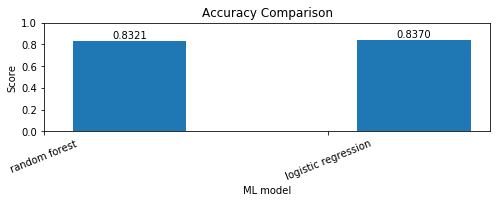

In [57]:
import operator
tup_results = sorted(dic_results.items(), key=operator.itemgetter(1))

N = len(dic_results)
ind = np.arange(N)  # the x locations for the groups
width = 0.40       # the width of the bars

fig = plt.figure(figsize=(8,2))
ax = fig.add_subplot(111)
rects = ax.bar(ind+0.5, list(zip(*tup_results))[1], width,)
for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x()+rect.get_width()/2., 
            1.005*height, 
            '{0:.4f}'.format(height), 
            ha='center', 
            va='bottom',)

ax.set_ylabel('Score')
ax.set_xlabel('ML model')
ax.set_ylim(ymin=0.0,ymax = 1)
ax.set_title("Accuracy Comparison")
ax.set_xticks(ind + width/2.)
ax.set_xticklabels(list(zip(*tup_results))[0], rotation=22)

plt.show()

# calculate final accuracy with a test set
So we see that the best validated model is Logistic Regression. We will now test it on the test set. We could also compare with other models with their respective best params.

### get best params of regressor
this was previously obtained during cross validation step

In [88]:
params = {}
for k,v in clf_logreg.best_params_.items():
    k = k[8:]
    params[k] = v
params

{'C': 1e-05, 'penalty': 'l1', 'random_state': 42}

In [89]:
#transform X_train
scale = StandardScaler().fit(X_train)
X_train_scaled = scale.transform(X_train)

#transform X_test
scale = StandardScaler().fit(X_test)
X_test_scaled = scale.transform(X_test)

#instantiate regressor with best params
clf_logreg_validated = LogisticRegression(C = params['C'], penalty = params['penalty'], random_state = params['random_state'])

                    
#fit regressor
clf_logreg_validated.fit(X_train_scaled, y_train)

#do prediction on test set
y_pred = clf_logreg_validated.predict(X_test_scaled)

### calculate accuracy on test set

In [90]:
accuracy_score(y_test, y_pred)

0.8620689655172413

### classification report

In [91]:
print("\nCLASSIFICATION_REPORT:\n", classification_report(y_test, y_pred))


CLASSIFICATION_REPORT:
               precision    recall  f1-score   support

           0       0.86      1.00      0.93       150
           1       0.00      0.00      0.00        24

    accuracy                           0.86       174
   macro avg       0.43      0.50      0.46       174
weighted avg       0.74      0.86      0.80       174

